# Libraries

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')


# Machine Learning models for exam

In [13]:
# Load the data
data = pd.read_csv('./cleaned_merged_course_data.csv')

# Convert 'Eksamensgennemsnit' to numeric (if not already done)
data['Eksamensgennemsnit'] = data['Eksamensgennemsnit'].str.replace(',', '.').astype(float)

# Sort the data by 'Course code' and 'Year'
data_sorted = data.sort_values(by=['Course code', 'Year'])

# Define the moving average period (e.g., 3 periods)
moving_average_period = 3

# Calculate the moving average for each 'Course code'
data_sorted['Moving_Average_GPA'] = data_sorted.groupby('Course code')['Eksamensgennemsnit'].transform(
    lambda x: x.rolling(window=moving_average_period, min_periods=1).mean()
)

# Save the DataFrame to a new CSV file
output_csv_path = './ML_data.csv'
data_sorted.to_csv(output_csv_path, index=False)

# Save the DataFrame to a new Excel file
output_excel_path = './ML_data.xlsx'
data_sorted.to_excel(output_excel_path, index=False)


In [14]:
def accuracy(prediction,test): #Function that calculates accuracy measure based on predicted values and the test set
    errors = abs(prediction - test_labels)
    mape_temp = 100 * abs(errors / test_labels)
    mape=np.mean(mape_temp[~np.isinf(mape_temp)])
    accuracy=100-mape
    MSE=np.mean(np.square(errors))
    print('MAE:', round(np.mean(errors), 5), 'grades.')
    print('MAPE:', round(mape, 5), '%.')
    print('Accuracy:', round(accuracy, 5), '%.')
    print('MSE:', round(MSE, 5))

In [15]:
# Define the WAC function
def WAC(x):
    return np.average(x.fillna(0), weights=Data.loc[x.index, 'Fremmødte'])

pd.set_option('display.max_columns', 50)

# Load the data
Data = pd.read_csv('ML_data.csv')

# Select the features we want to use for prediction
Input_values = Data[['Course code', 'Year', 'Season', 'Antal bestået', 'Antal tilmeldte', 
                     'Eksamensgennemsnit', 'Moving_Average_GPA', 'Fremmødte', 'Point( ECTS )', 'Kursustype', 
                     'Evalueringsform', 'Bedømmelsesform', 'Institut'] + Data.columns.tolist()[-11:]]

# Extract the labels
Output_values = np.array(Input_values['Eksamensgennemsnit'])

# Drop unnecessary columns from the input
Input_values = Input_values.drop(['Season', 'Institut', 'Course code', 'Kursustype', 'Eksamensgennemsnit'], axis=1)
Input_values['Moving_Average_GPA'].fillna(WAC(Data['Eksamensgennemsnit']), inplace=True)
Input_values = pd.get_dummies(Input_values)

# Deduplicate the columns if necessary
Input_values = Input_values.loc[:, ~Input_values.columns.duplicated()]

# Save column headers
Input_values_list = list(Input_values.columns)

# Convert the dataframe to a numpy array
Input_values = np.array(Input_values)

# Split the data into training and test sets
train_features, test_features, train_labels, test_labels = train_test_split(
    Input_values, Output_values, test_size=0.30, random_state=1)

# Print the shapes of the resulting datasets
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)


Training Features Shape: (5033, 38)
Training Labels Shape: (5033,)
Testing Features Shape: (2158, 38)
Testing Labels Shape: (2158,)


## Ordinary Least Squares (OLS) Regression

In [16]:
#Scaling data
scaler=StandardScaler().fit(train_features)
sc_train_features=scaler.transform(train_features)
sc_test_features=scaler.transform(test_features)

In [17]:
#Fitting OLS model on the training data
ols=linear_model.LinearRegression()
ols.fit(sc_train_features,train_labels)

LinearRegression()

In [18]:
#Predicting using the trained OLS model and calculating the models accuracy
predict_ols = ols.predict(sc_test_features)
accuracy(predict_ols, test_labels)

MAE: 0.4811 grades.
MAPE: 8.81217 %.
Accuracy: 91.18783 %.
MSE: 0.53052


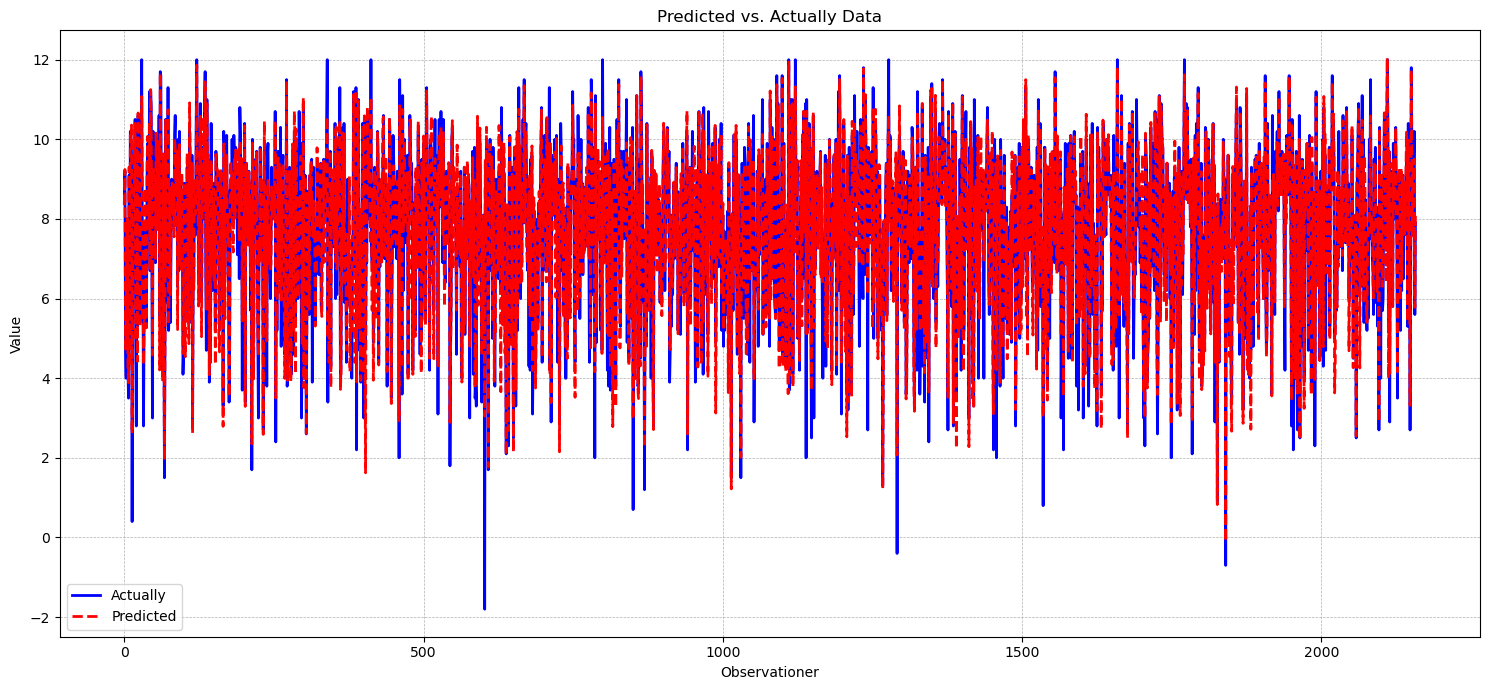

In [37]:
import matplotlib.pyplot as plt
import numpy as np
# Create an array of numbers for the x-axis based on the length of the data
x_axis = np.arange(len(test_labels))

plt.figure(figsize=(15,7))
plt.plot(x_axis, test_labels, label='Actually', color='blue', linewidth=2)
plt.plot(x_axis, predict_ols, label='Predicted', color='red', linestyle='--', linewidth=2)
plt.title('Predicted vs. Actually Data')
plt.xlabel('Observationer')
plt.ylabel('Value')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## Lasso

In [20]:
#Fitting the lasso model and predict using the standardized alpha 
lasso_reg=Lasso()
lasso_reg.fit(sc_train_features,train_labels)
lasso_predict=lasso_reg.predict(sc_test_features)
accuracy(lasso_predict, test_labels)

MAE: 0.97584 grades.
MAPE: 19.23315 %.
Accuracy: 80.76685 %.
MSE: 1.57765


In [21]:
#Using GridSearch to find optimal size of hyperparameter
lasso_reg=Lasso()
param_grid={'alpha':np.logspace(-4,4,12)}
grid_search_lasso = GridSearchCV(estimator = lasso_reg, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

grid_search_lasso.fit(sc_train_features,train_labels)
grid_search_lasso.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.374e+02, tolerance: 1.778e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.041e+02, tolerance: 1.768e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

[CV] END .......................................alpha=0.0001; total time=   0.2s
[CV] END .......................................alpha=0.0001; total time=   0.2s
[CV] END .......................................alpha=0.0001; total time=   0.2s
[CV] END .......................................alpha=0.0001; total time=   0.2s
[CV] END .......................................alpha=0.0001; total time=   0.2s
[CV] END ........................alpha=0.0005336699231206312; total time=   0.2s
[CV] END ........................alpha=0.0005336699231206312; total time=   0.2s
[CV] END .........................alpha=0.002848035868435802; total time=   0.1s
[CV] END ........................alpha=0.0005336699231206312; total time=   0.2s
[CV] END .........................alpha=0.002848035868435802; total time=   0.1s
[CV] END .........................alpha=0.002848035868435802; total time=   0.1s
[CV] END ..........................alpha=0.01519911082952933; total time=   0.0s
[CV] END ...................

{'alpha': 0.002848035868435802}

In [22]:
#Fitting the new model with the above optimal hyperparameter and predicting
best_grid_lasso = grid_search_lasso.best_estimator_ 
predictions_best_grid_lasso = best_grid_lasso.predict(sc_test_features)
accuracy(predictions_best_grid_lasso, test_labels)

MAE: 0.47804 grades.
MAPE: 8.7898 %.
Accuracy: 91.2102 %.
MSE: 0.53281


### Plot of Lasso predictions

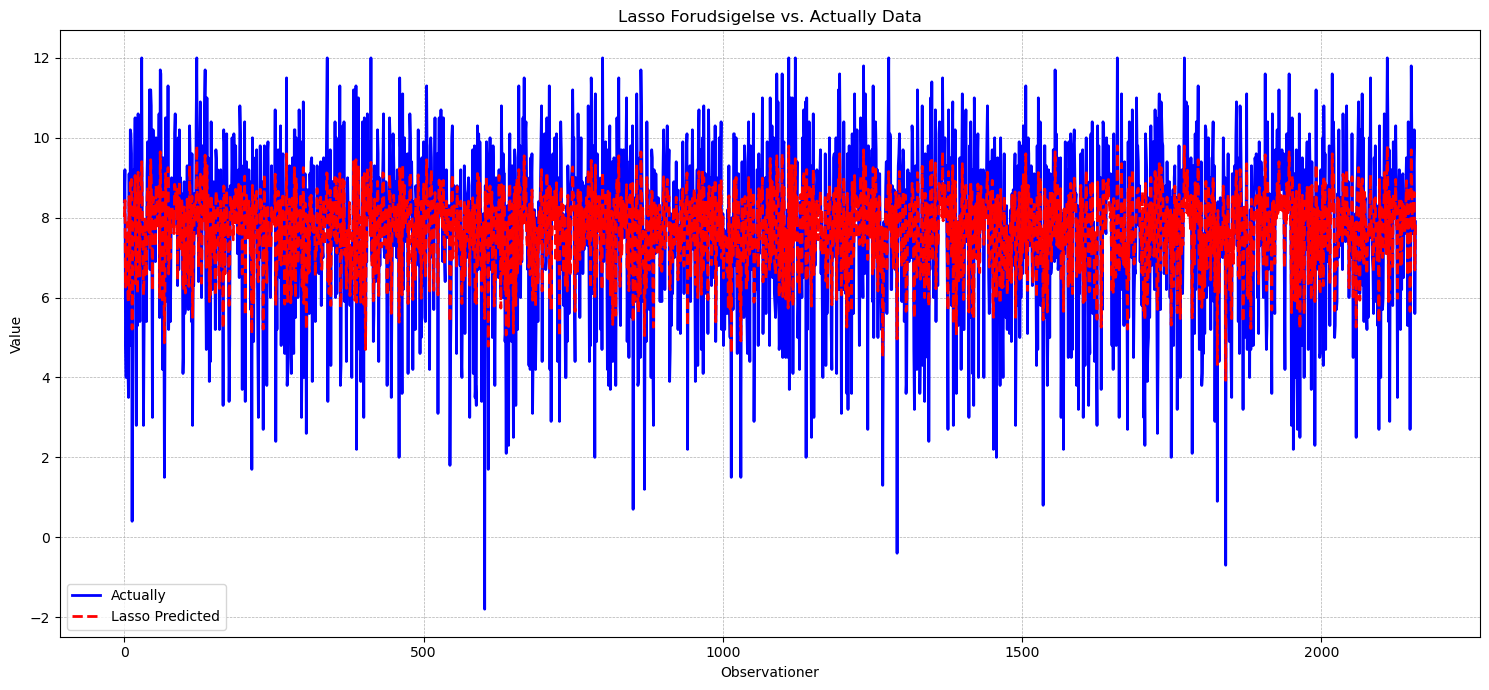

In [36]:
import matplotlib.pyplot as plt
import numpy as np


# Create an array of numbers for the x-axis based on the length of the data
x_axis = np.arange(len(test_labels))

plt.figure(figsize=(15,7))
plt.plot(x_axis, test_labels, label='Actually', color='blue', linewidth=2)
plt.plot(x_axis, lasso_predict, label='Lasso Predicted', color='red', linestyle='--', linewidth=2)
plt.title('Lasso Forudsigelse vs. Actually Data')
plt.xlabel('Observationer')
plt.ylabel('Value')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

### Coefficients from Lasso

In [24]:

# Get the coefficients from the optimal Lasso model
lasso_coefficients = best_grid_lasso.coef_

# Create a DataFrame
coeff_df_lasso = pd.DataFrame(lasso_coefficients, Input_values_list, columns=['Coefficient'])
coeff_df_lasso = coeff_df_lasso.sort_values(by='Coefficient', key=lambda x: x.abs(), ascending=False)

coeff_df_lasso
coeff_df_lasso.head(60)

,Coefficient
Moving_Average_GPA,1.937575e+00
Antal bestået,2.692019e-01
Fremmødte,-2.169220e-01
Year,-3.210030e-02
Point( ECTS )_15,1.430755e-02
Evalueringsform_Skriftlig og mundtlig eksamen,-1.357582e-02
Ekstern samarbejdsinstitution_Ja,1.318074e-02
Point( ECTS )_8,1.235874e-02
forudsætninger_Ja,1.029366e-02
Point( ECTS )_20,-1.000355e-02


## Ridge

In [25]:
#Fitting the Ridge model and predict using the standardized alpha
Ridge_reg=Ridge()
Ridge_reg.fit(sc_train_features,train_labels)
Ridge_predict=Ridge_reg.predict(sc_test_features)
accuracy(Ridge_predict, test_labels)

MAE: 0.48062 grades.
MAPE: 8.80485 %.
Accuracy: 91.19515 %.
MSE: 0.53044


In [26]:
#Using gridsearch to find optimal size of hyperparameter, note that more possible alpha is being looked after
Ridge_reg=Ridge()
param_grid={'alpha':np.logspace(-5,5,50)}
grid_search_Ridge = GridSearchCV(estimator = Ridge_reg, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

grid_search_Ridge.fit(sc_train_features,train_labels)
grid_search_Ridge.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ........................................alpha=1e-05; total time=   0.0s
[CV] END ........................................alpha=1e-05; total time=   0.0s
[CV] END ........................................alpha=1e-05; total time=   0.0s
[CV] END ........................................alpha=1e-05; total time=   0.0s
[CV] END ........................................alpha=1e-05; total time=   0.0s
[CV] END .......................alpha=1.5998587196060572e-05; total time=   0.0s
[CV] END .......................alpha=1.5998587196060572e-05; total time=   0.0s
[CV] END .......................alpha=1.5998587196060572e-05; total time=   0.0s
[CV] END .......................alpha=1.5998587196060572e-05; total time=   0.0s
[CV] END .......................alpha=1.5998587196060572e-05; total time=   0.0s
[CV] END ........................alpha=2.559547922699533e-05; total time=   0.0s
[CV] END ........................alpha=2.559547

{'alpha': 5.1794746792312125}

In [27]:
#Fitting the new model with the above optimal hyperparameter and predicting
best_grid_Ridge = grid_search_Ridge.best_estimator_
predictions_best_grid_Ridge = best_grid_Ridge.predict(sc_test_features)
accuracy(predictions_best_grid_Ridge, test_labels)

MAE: 0.47982 grades.
MAPE: 8.79368 %.
Accuracy: 91.20632 %.
MSE: 0.53066


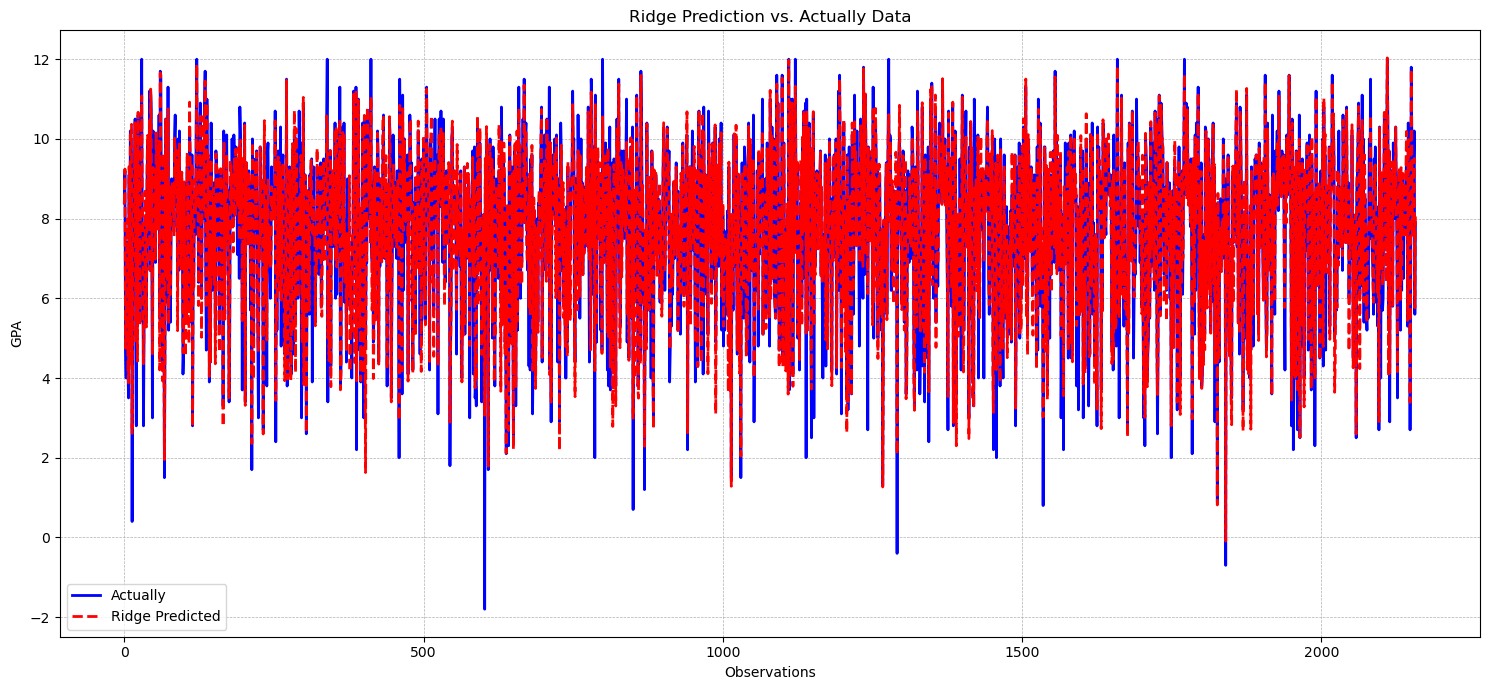

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Create an array of numbers for the x-axis based on the length of the data
x_axis = np.arange(len(test_labels))

# Plot figure
plt.figure(figsize=(15,7))
plt.plot(x_axis, test_labels, label='Actually', color='blue', linewidth=2)
plt.plot(x_axis, predictions_best_grid_Ridge, label='Ridge Predicted', color='red', linestyle='--', linewidth=2)
plt.title('Ridge Prediction vs. Actually Data')
plt.xlabel('Observations')
plt.ylabel('GPA')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

### Coefficients for Ridge

In [29]:

# Get the coefficients from the optimal Lasso model
Ridge_coefficients = best_grid_Ridge.coef_

coeff_df_ridge = pd.DataFrame(Ridge_coefficients, Input_values_list, columns=['Coefficient'])
coeff_df_ridge = coeff_df_ridge.sort_values(by='Coefficient', key=lambda x: x.abs(), ascending=False)

coeff_df_ridge[:97]

,Coefficient
Moving_Average_GPA,1.925007
Fremmødte,-0.710908
Antal bestået,0.516655
Antal tilmeldte,0.245006
Year,-0.035677
Point( ECTS )_15,0.017031
Evalueringsform_Skriftlig og mundtlig eksamen,-0.015638
Point( ECTS )_8,0.015161
Point( ECTS )_6,0.012436
Point( ECTS )_3,0.012344


## Random Forrest Regressor

In [30]:
#Beforehand -finding an baseline prediction to make sure machine learning better the prediction
baseline_preds = 7
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  1.86


In [31]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels)

RandomForestRegressor(n_estimators=1000, random_state=42)

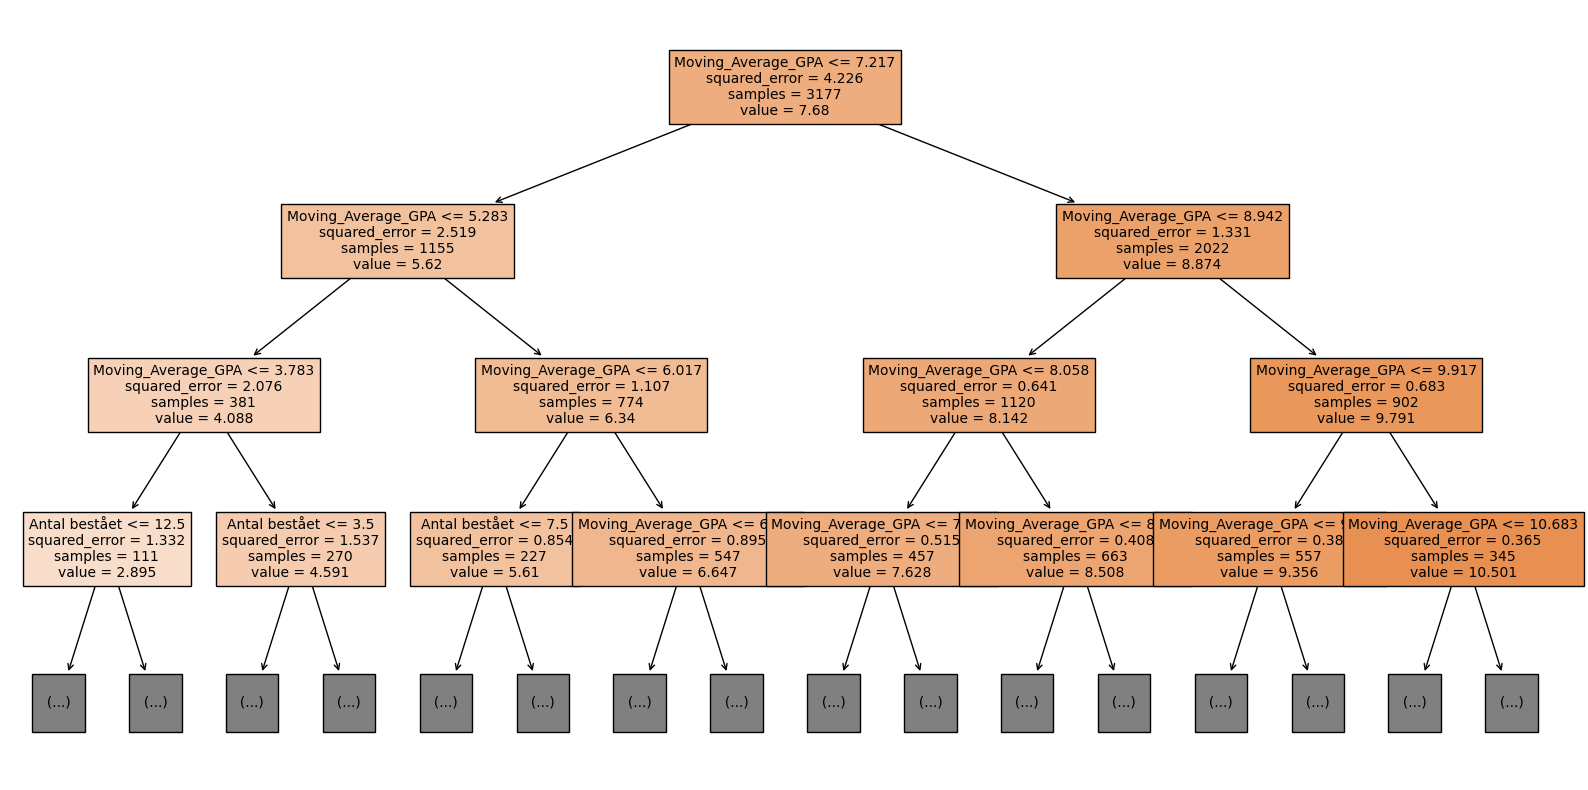

In [32]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Choose a tree from the forrest (in this case the first tree)
tree = rf.estimators_[0]

plt.figure(figsize=(20,10))
plot_tree(tree, filled=True, feature_names=Input_values_list, max_depth=3, fontsize=10)
plt.show()

In [33]:
# Use the random forest predict method on the test data
predictions = rf.predict(test_features)

accuracy(predictions,test_labels)

MAE: 0.5007 grades.
MAPE: 8.65742 %.
Accuracy: 91.34258 %.
MSE: 0.5231


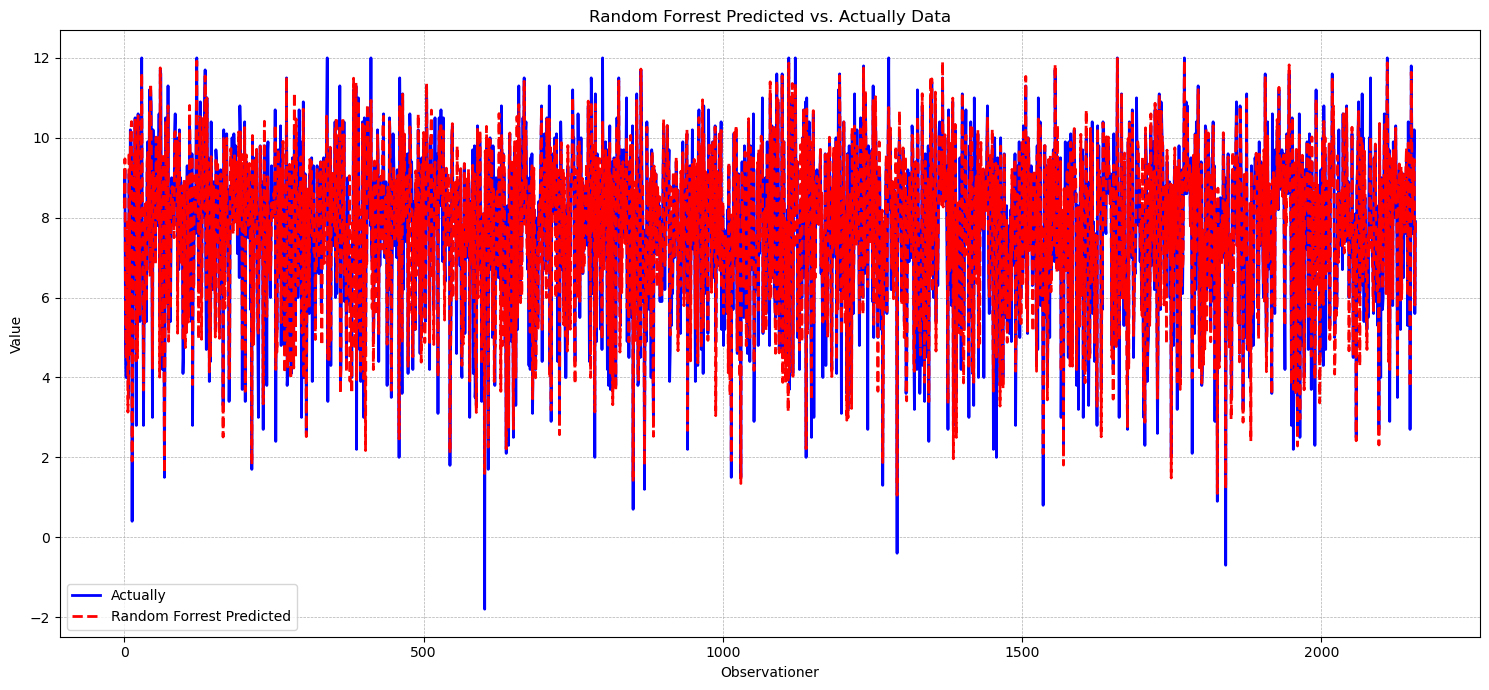

In [38]:
import matplotlib.pyplot as plt
import numpy as np


# Create an array of numbers for the x-axis based on the length of the data
x_axis = np.arange(len(test_labels))

#Plot figure
plt.figure(figsize=(15,7))
plt.plot(x_axis, test_labels, label='Actually', color='blue', linewidth=2)
plt.plot(x_axis, predictions, label='Random Forrest Predicted', color='red', linestyle='--', linewidth=2)
plt.title('Random Forrest Predicted vs. Actually Data')
plt.xlabel('Observationer')
plt.ylabel('Value')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()